# Outliers detection

To further investigate potential artifacts in the sequencing data after technical filtering, CNVs were visualized using boxplots that represented the number and average length of CNVs per individual, along with the overall size distribution of all CNVs. For individuals flagged as suspicious, further analysis was conducted to determine the chromosomes involved and the proportion of CNVs occurring on each, allowing potential sources of the artifacts to be identified.


In [239]:
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import kruskal, chi2_contingency
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests
import sys, os
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [285]:
cnv_df = pd.read_csv("../results/merged_all_cnv_annotations.csv")

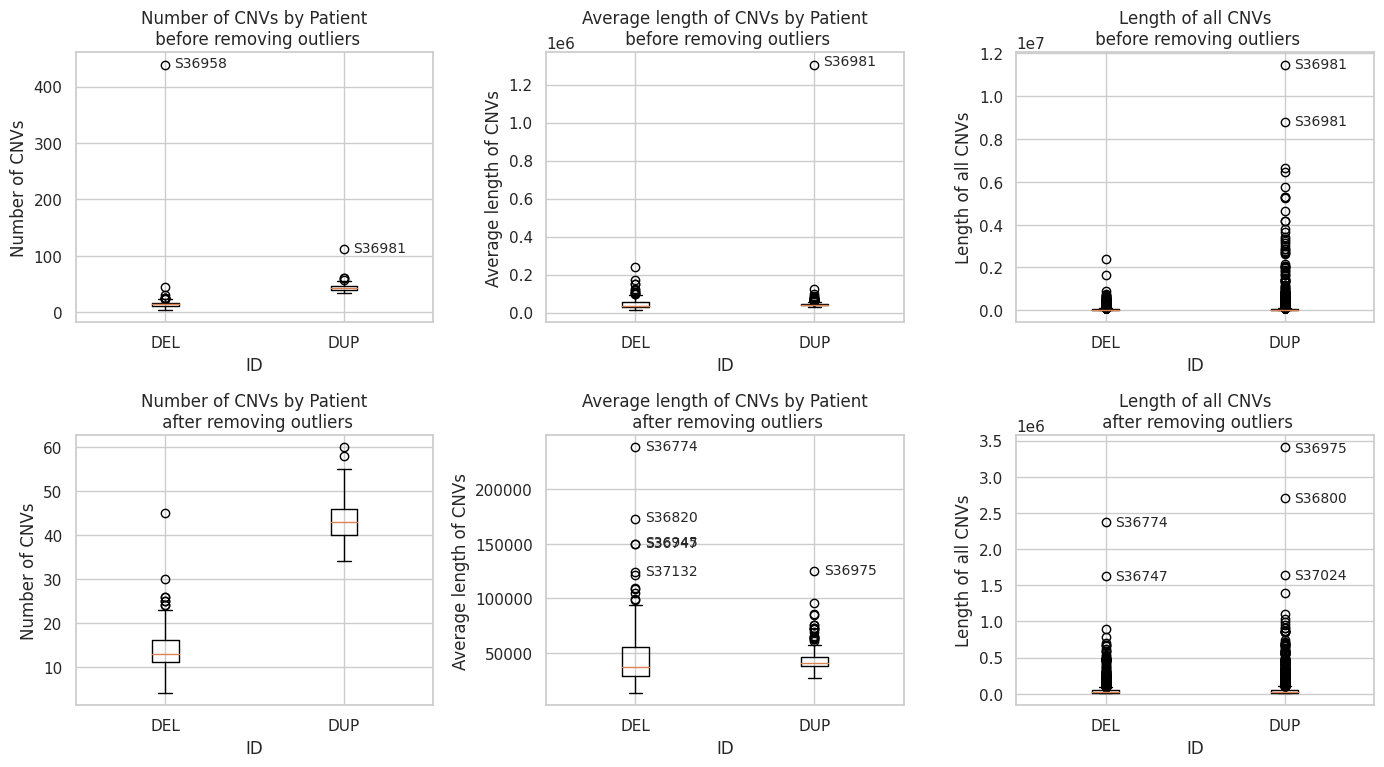

In [286]:
def plot_boxplot(ax, del_data, dup_data, title, xlabel, ylabel, 
                 outlier_threshold, annotation_offset, annotate=False, label_suffix=""):
    ax.boxplot([del_data, dup_data], labels=[f"DEL{label_suffix}", f"DUP{label_suffix}"])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if annotate:
        # Annotate outliers for DEL
        del_outliers = del_data[del_data > outlier_threshold].index.to_list()
        for i, j in zip(del_outliers, del_data[del_data > outlier_threshold][del_outliers]):
            ax.annotate(str(i), (1.2, j - annotation_offset), 
                        textcoords="offset points",
                        xytext=(0, 10), ha="center", fontsize=10)

        # Annotate outliers for DUP
        dup_outliers = dup_data[dup_data > outlier_threshold].index.to_list()
        for i, j in zip(dup_outliers, dup_data[dup_data > outlier_threshold][dup_outliers]):
            ax.annotate(str(i), (2.2, j - annotation_offset), 
                        textcoords="offset points",
                        xytext=(0, 10), ha="center", fontsize=10)

def generate_plots(cnv_df, ax, title_suffix, thresholds, 
                   annotation_offsets, annotate=False, label_suffix=""):
    plot_configs = [
        {
            "group_func": lambda df: df.groupby("ID").size(),
            "title": f"Number of CNVs by Patient\n {title_suffix}",
            "xlabel": "ID",
            "ylabel": "Number of CNVs",
            "outlier_threshold": thresholds[0],
            "annotation_offset": annotation_offsets[0],
        },
        {
            "group_func": lambda df: df.groupby("ID")["CNV_length"].mean(),
            "title": f"Average length of CNVs by Patient\n {title_suffix}",
            "xlabel": "ID",
            "ylabel": "Average length of CNVs",
            "outlier_threshold": thresholds[1],
            "annotation_offset": annotation_offsets[1],
        },
        {
            "group_func": lambda df: df.set_index("ID")["CNV_length"],
            "title": f"Length of all CNVs\n {title_suffix}",
            "xlabel": "ID",
            "ylabel": "Length of all CNVs",
            "outlier_threshold": thresholds[2],
            "annotation_offset": annotation_offsets[2],
        }
    ]

    for i, config in enumerate(plot_configs):
        del_data = config["group_func"](cnv_df[cnv_df["Type"] == "DEL"])
        dup_data = config["group_func"](cnv_df[cnv_df["Type"] == "DUP"])
        plot_boxplot(ax[i], del_data, dup_data, 
                     config["title"], config["xlabel"], config["ylabel"],
                     config["outlier_threshold"], config["annotation_offset"],
                     annotate=annotate, label_suffix=label_suffix)

# Initialize CNV length
cnv_df["CNV_length"] = cnv_df["End"] - cnv_df["Start"]

# Define thresholds for before and after
before_thresholds = [100, 1_000_000, 8_000_000]
after_thresholds = [70, 122_000, 1_500_000]

# Define annotation offsets for before and after
before_annotation_offsets = [30, 77_000, 800_000]
after_annotation_offsets = [10, 15_000, 250_000]

# Plot
fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Before removing outliers
generate_plots(cnv_df, ax[0], "before removing outliers", 
               before_thresholds, before_annotation_offsets, annotate=True)

# After removing outliers
cnv_filtered_df = cnv_df[~cnv_df["ID"].isin(['S36958', 'S36981'])]
generate_plots(cnv_filtered_df, ax[1], "after removing outliers", 
               after_thresholds, after_annotation_offsets, annotate=True)

plt.tight_layout()
plt.show()


Individuals S36958 and S36981 emerge as distinct outliers — S36958 with respect to the number of CNVs, and S36981 concerning the length of CNVs. These individuals are subjected to a more detailed analysis, which presents the distribution of deletions and duplications per chromosome for these outliers in comparison to the cohort’s median values.

In [287]:
# Chromosome lengths dictionary
chromosome_lengths = {
    "chr1": 248956422, "chr2": 242193529, "chr3": 198295559, "chr4": 190214555, 
    "chr5": 181538259, "chr6": 170805979, "chr7": 159345973, "chr8": 145138636, 
    "chr9": 138394717, "chr10": 133797422, "chr11": 135086622, "chr12": 133275309, 
    "chr13": 114364328, "chr14": 107043718, "chr15": 101991189, "chr16": 90338345, 
    "chr17": 83257441, "chr18": 80373285, "chr19": 58617616, "chr20": 64444167, 
    "chr21": 46709983, "chr22": 50818468, "chrX": 156040895
}

/tmp/ipykernel_2997/1366032846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_df['CNV_Size'] = individual_df['End'] - individual_df['Start']
/tmp/ipykernel_2997/1366032846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_df['CNV_Size'] = individual_df['End'] - individual_df['Start']


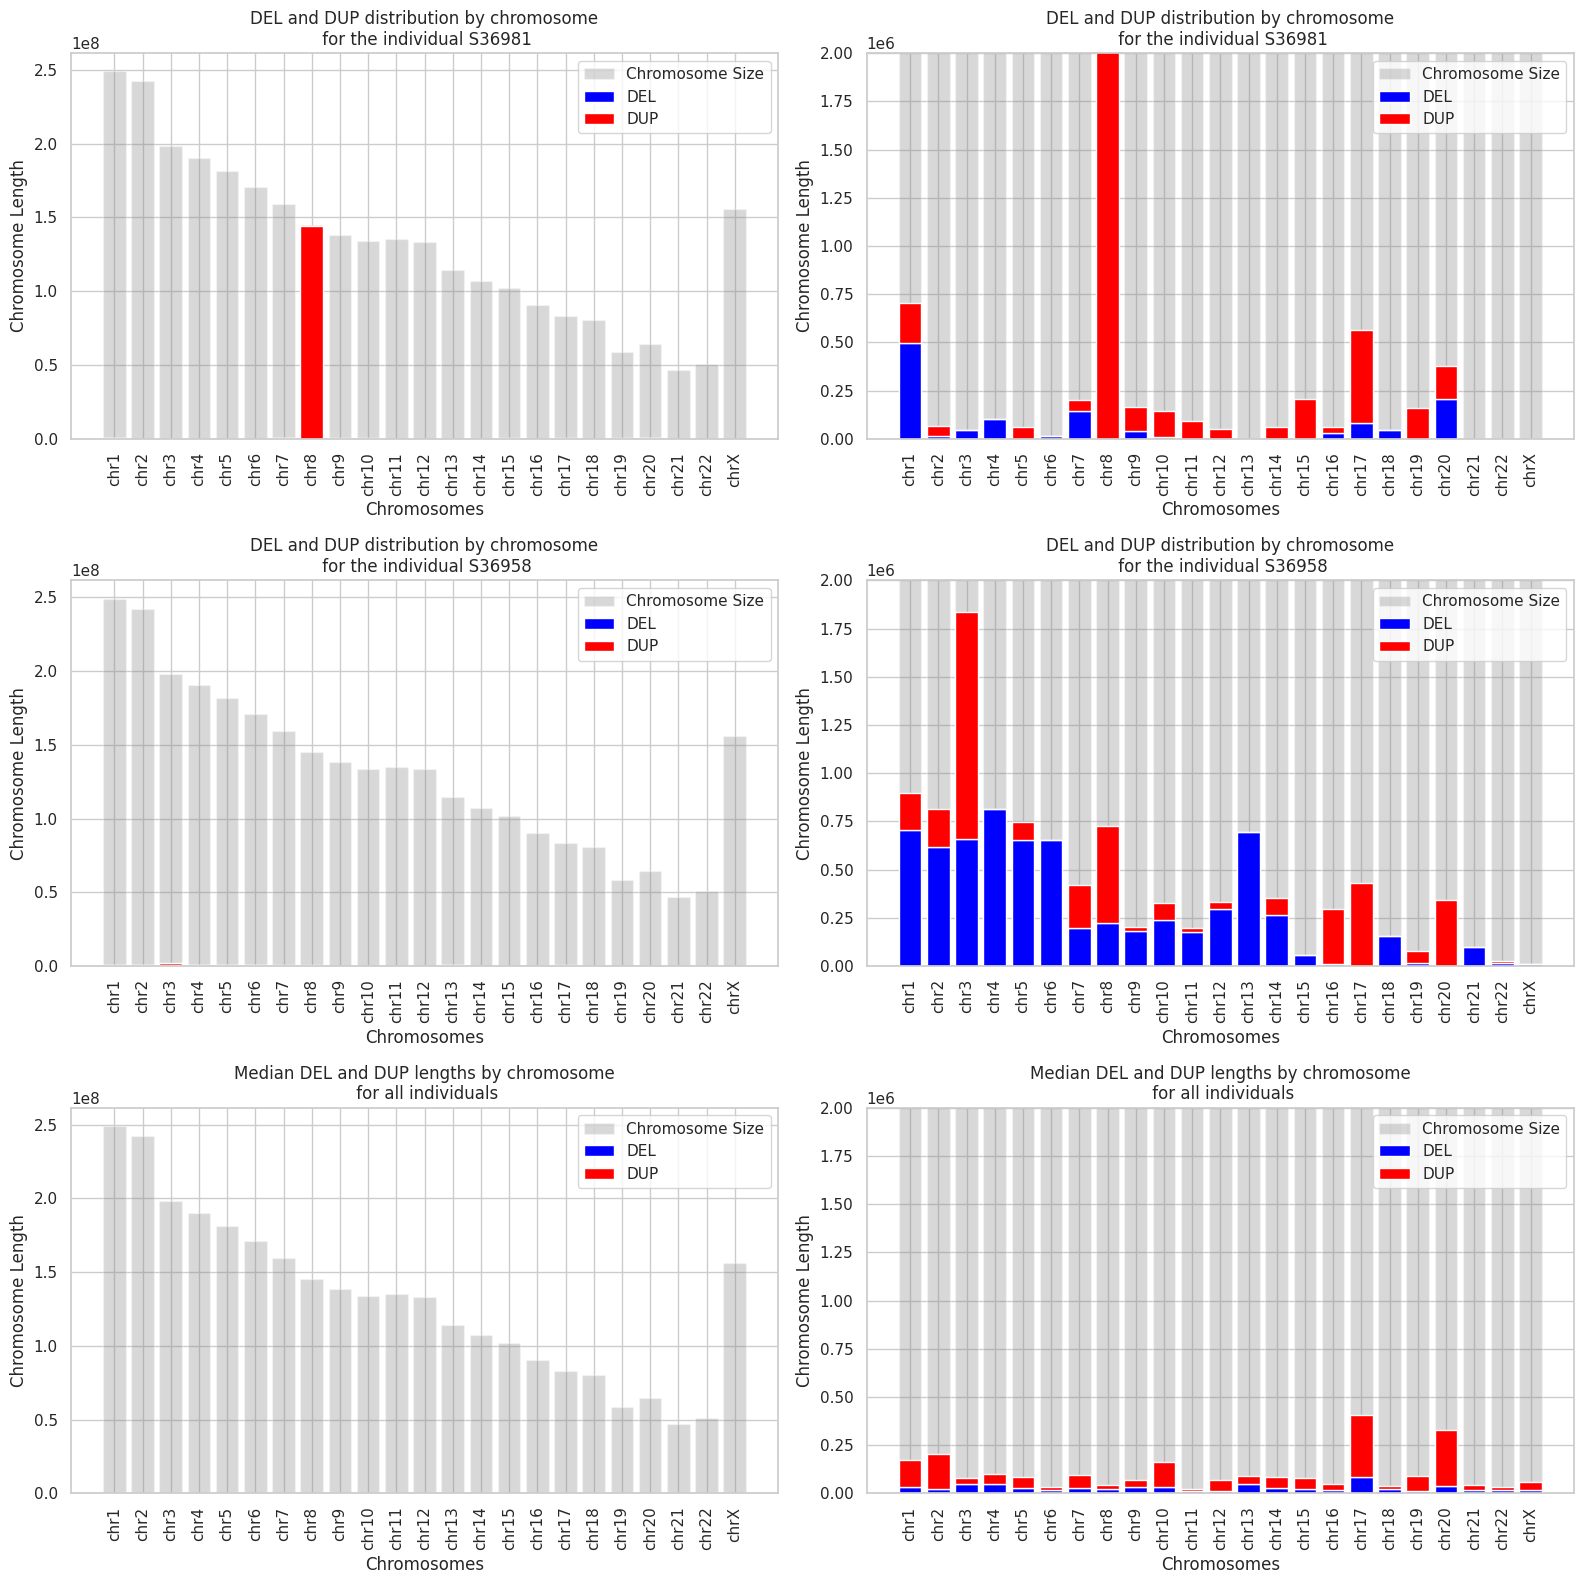

In [288]:
def calculate_cnv_lengths(individual_id, cnv_df):
    # Filter data for the given individual and type DEL or DUP
    individual_df = cnv_df[(cnv_df['ID'] == individual_id) & (cnv_df['Type'].isin(['DEL', 'DUP']))]
    
    # Calculate the CNV sizes
    individual_df['CNV_Size'] = individual_df['End'] - individual_df['Start']
    
    # Separate DELs and DUPs, then group by chromosome and sum the CNV sizes
    del_cumulative = (individual_df[individual_df['Type'] == 'DEL']
                      .groupby('Chromosome')['CNV_Size'].sum())
    
    dup_cumulative = (individual_df[individual_df['Type'] == 'DUP']
                      .groupby('Chromosome')['CNV_Size'].sum())
    
    # Ensure all chromosomes are included (even those without events)
    del_cumulative = del_cumulative.reindex(chromosome_lengths.keys(), fill_value=0)
    dup_cumulative = dup_cumulative.reindex(chromosome_lengths.keys(), fill_value=0)
    
    return del_cumulative, dup_cumulative

def calculate_median_cnv_lengths(cnv_df):
    # Calculate DEL and DUP sizes for all individuals combined
    cnv_df['CNV_Size'] = cnv_df['End'] - cnv_df['Start']
    
    del_median = cnv_df[cnv_df['Type'] == 'DEL'].groupby(['Chromosome', 'ID'])['CNV_Size'].sum().groupby('Chromosome').median()
    dup_median = cnv_df[cnv_df['Type'] == 'DUP'].groupby(['Chromosome', 'ID'])['CNV_Size'].sum().groupby('Chromosome').median()
    
    del_median = del_median.reindex(chromosome_lengths.keys(), fill_value=0)
    dup_median = dup_median.reindex(chromosome_lengths.keys(), fill_value=0)
    
    return del_median, dup_median


# Calculate CNV lengths for individuals
del_s6981, dup_s6981 = calculate_cnv_lengths('S36981', cnv_df)
del_s6958, dup_s6958 = calculate_cnv_lengths('S36958', cnv_df)

# Calculate median CNV lengths for all individuals
del_median, dup_median = calculate_median_cnv_lengths(cnv_df)

# Plotting the results
chromosomes_sorted = [f'chr{i}' for i in range(1, 23)] + ['chrX']
chromosome_sizes = [chromosome_lengths[chr] for chr in chromosomes_sorted]

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Plot for individual S6981
for i, (del_data, dup_data, title) in enumerate([
    (del_s6981, dup_s6981, 'DEL and DUP distribution by chromosome\n for the individual S36981'),
    (del_s6958, dup_s6958, 'DEL and DUP distribution by chromosome\n for the individual S36958'),
    (del_median, dup_median, 'Median DEL and DUP lengths by chromosome\n for all individuals')
]):
    ax = axes[i*2]
    ax.bar(chromosomes_sorted, chromosome_sizes, color='grey', alpha=0.3, label='Chromosome Size')
    ax.bar(chromosomes_sorted, [del_data[chr] for chr in chromosomes_sorted],
           color='blue', label='DEL')
    ax.bar(chromosomes_sorted, [dup_data[chr] for chr in chromosomes_sorted],
           bottom=[del_data[chr] for chr in chromosomes_sorted],
           color='red', label='DUP')
    ax.set_xlabel('Chromosomes')
    ax.set_ylabel('Chromosome Length')
    ax.set_title(title)
    ax.set_xticks(range(len(chromosomes_sorted)))
    ax.set_xticklabels(chromosomes_sorted, rotation=90)
    ax.legend()
    
    ax = axes[i*2 + 1]
    ax.bar(chromosomes_sorted, chromosome_sizes, color='grey', alpha=0.3, label='Chromosome Size')
    ax.bar(chromosomes_sorted, [del_data[chr] for chr in chromosomes_sorted],
           color='blue', label='DEL')
    ax.bar(chromosomes_sorted, [dup_data[chr] for chr in chromosomes_sorted],
           bottom=[del_data[chr] for chr in chromosomes_sorted],
           color='red', label='DUP')
    ax.set_xlabel('Chromosomes')
    ax.set_ylabel('Chromosome Length')
    ax.set_title(title)
    ax.set_xticks(range(len(chromosomes_sorted)))
    ax.set_xticklabels(chromosomes_sorted, rotation=90)
    ax.legend()
    ax.set_ylim(0, 2_000_000)

plt.tight_layout()
plt.show()


The analysis revealed that individual S36981 exhibited a nearly complete duplication of chromosome 8, while individual S36958 displayed highly elevated levels of both deletions and duplications across all chromosomes relative to the median. These anomalies suggest potential sequencing artifacts, likely arising from technical errors during the sequencing process such as amplification bias, alignment errors, or issues related to DNA sample quality. Such artifacts can lead to incorrect CNV detection, particularly in repetitive genomic regions.